In [1]:
# importing required libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 

from IPython.display import clear_output, display

from tensorflow import Variable, Tensor
from tensorflow import GradientTape 
from tensorflow.keras.optimizers import Optimizer
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from keras import Model

from time import time

from .image import load_image
from .image import tensor_to_image

from .save import add_frame
from .save import save_convertion

from .processing import preprocessing_img

from .compute import compute_and_optimize_gradient

In [2]:
def load_vgg19()-> Model:
    vgg = VGG19(include_top=False, weights='imagenet')
    return vgg

def create_model(content_layers : list)-> Model:

    vgg19 = load_vgg19()
    name = content_layers[0]
    layer = vgg19.get_layer(name)
    output = layer.output

    model = Model([vgg19.input], output)
    model.trainable = False

    return (model)

def get_features_map(model : Model, img : Tensor)->list:

        process_img = preprocessing_img(img)
        features_map = model(process_img)

        return (features_map)
    
def create_noisy_imag(img : Tensor):
    
    noise_filter = np.random.randn(*img.shape)
    return (noise_filter)

def clip_pixel(image : Tensor):
  
    cliped_imag = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    return (cliped_imag)

def create_batch_image(img : Tensor):

    img = tf.expand_dims(tf.constant(img),axis=0)
    return (img)

def extract_content(features_map):

    content = features_map[0]
    return (content)

def init_content_target(model : Model, content_img : Tensor):

    content_img = create_batch_image(content_img)
    features_map = get_features_map(model, content_img)
    content_target = extract_content(features_map)

    return (content_target)

def init_generated_img(content_img : Tensor):

    
    generated_img = create_noisy_imag(content_img)
    generated_img = clip_pixel(generated_img)
    generated_img = create_batch_image(generated_img)
    generated_img = Variable(generated_img)

    return (generated_img)


def compute_content_loss(content_generated : Tensor, 
                         content_target : Tensor):
    
    content_loss = tf.reduce_mean((content_generated - content_target)**2)
    return (content_loss)

@tf.function
def update_content(model : Model,
                 content_target : Tensor, 
                 generated_img : Variable,
                 optimizer : Optimizer):

    with GradientTape() as tape :

        features_map = get_features_map(model, generated_img)
        content_generated = extract_content(features_map)
        
        loss = compute_content_loss(content_generated, content_target)

    generated_img = compute_and_optimize_gradient(tape,
                                                  optimizer, 
                                                  generated_img,
                                                  loss)

In [3]:
def display_generated_img(generated_img : Variable):
    
    clear_output(wait=True)
    display(tensor_to_image(generated_img))

In [4]:
class Model_Content_Representation:

    def __init__(self, optimizer=Adam(learning_rate=0.02), style_weight=1e6, content_weight=5e0, noise_ratio=0.20):
        super().__init__()
        self.optimizer = optimizer
        self.content_layers = ['block5_conv2']
        self.model = create_model(self.content_layers)
        self.content_img = None
        self.generated_img = None
        self.frames = list()

    def import_img(self, content_img):

        self.content_img = load_image(content_img)
        plt.imshow(self.content_img)

    def recreate_content(self, num_epochs,):

        target_content = init_content_target(self.model, self.content_img)
        self.generated_img = init_generated_img(self.content_img)
        plt.imshow(tensor_to_image(self.generated_img))
        
        start = time()
        for epoch in range(num_epochs) :

            update_content(self.model,
                         target_content, 
                         self.generated_img, 
                         self.optimizer)

            display_generated_img(self.generated_img) 
             
        end = time()
        print("Total training time: {:.1f} seconds".format(end-start))

In [5]:
Model = Model_Content_Representation()

2022-11-15 10:51:04.222820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 10:51:04.250450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 10:51:04.250696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 10:51:04.251514: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

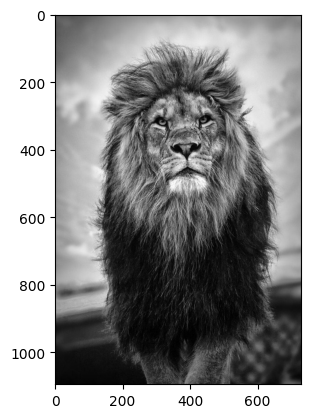

In [6]:
Model.import_img('img/content/content_img.jpg')

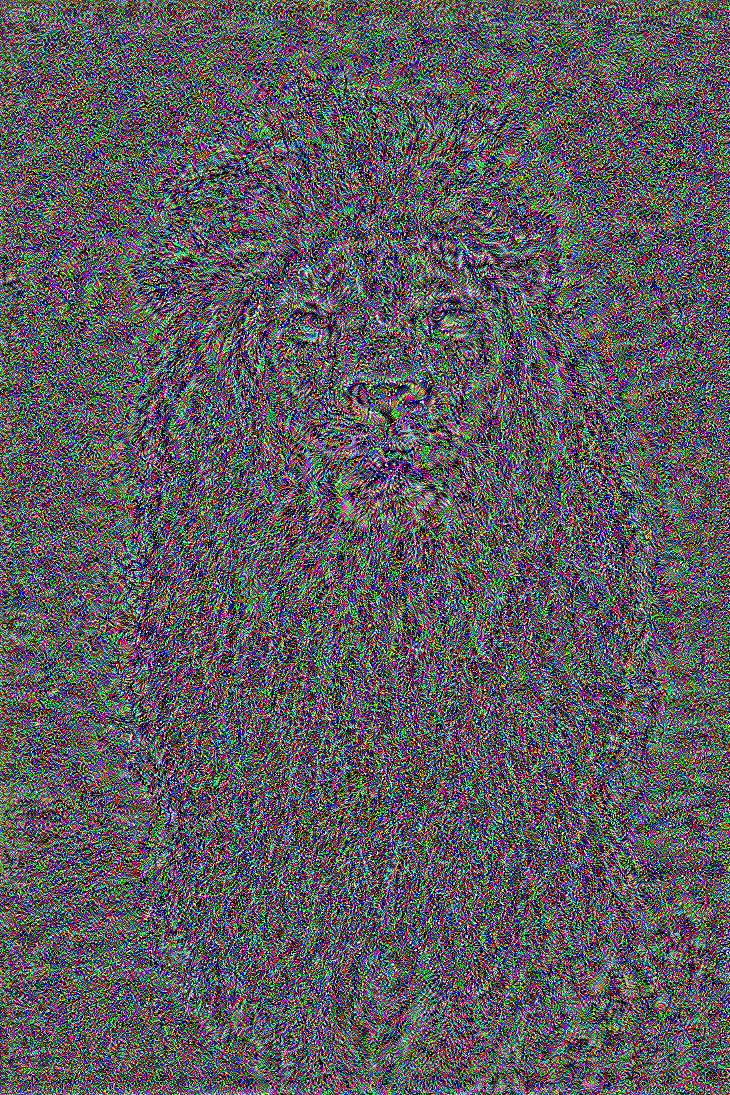

Total training time: 46.2 seconds


<tf.Variable 'Variable:0' shape=(1, 1095, 730, 3) dtype=float64, numpy=
array([[[[2.41087511e-01, 2.08518238e-01, 8.06986184e-01],
         [5.24213931e-02, 5.75597788e-01, 3.89142548e-01],
         [6.56315076e-01, 8.70629398e-02, 1.57678600e-01],
         ...,
         [2.00080098e-02, 4.83682629e-01, 5.41970137e-01],
         [5.25286562e-02, 1.89755943e-01, 4.56935793e-01],
         [1.02613499e-01, 5.04798049e-01, 1.67013706e-01]],

        [[1.99672040e-01, 3.56503983e-01, 4.82088046e-01],
         [9.07374212e-01, 2.64506028e-01, 3.23532487e-01],
         [4.47520827e-01, 6.28983135e-01, 8.58872402e-03],
         ...,
         [1.89316362e-01, 7.93069939e-01, 0.00000000e+00],
         [5.04950100e-02, 0.00000000e+00, 0.00000000e+00],
         [2.62548376e-01, 3.66910792e-01, 9.74326708e-02]],

        [[3.51815412e-01, 3.22567580e-01, 3.24186695e-01],
         [4.69995175e-01, 2.58592164e-01, 2.85252598e-01],
         [8.66571751e-04, 5.85618289e-01, 6.93744015e-01],
         ..

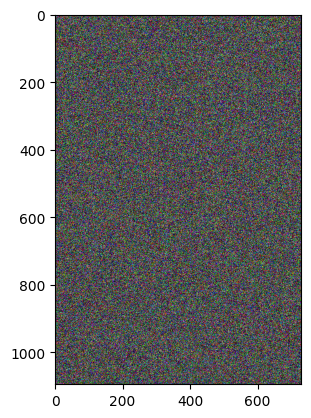

In [7]:
Model.recreate_content(100)